First updated @ Nov 2, 2021

Last updated @ Dec 5, 2021

In [1]:
import pandas as pd
import ast
from collections import defaultdict
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotnine import *
from scipy import stats
from scipy.stats import norm

## Load 3 datasets

- The Bechdel data (only has imdb id)
- The credits data (only has tmdb id)
- The links data, which has both imdb id and tmdb id, so that we can join the three datasets together to get the movies we want.

In [2]:
# load bechdel data
bechdel_df = pd.read_csv('./Data/Bechdel_detailed.csv')
bechdel_df.rename(columns={'rating': 'bt_score'}, inplace=True) # I find the name rating a little confusing
bechdel_df

,title,year,bt_score,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,9602.0,18880.0,2021-04-02 20:58:09,1.0
1,La Rosace Magique,1877.0,0.0,0.0,14495706.0,9804.0,19145.0,2021-05-11 00:11:22,1.0
2,Sallie Gardner at a Gallop,1878.0,0.0,0.0,2221420.0,9603.0,18882.0,2021-04-03 02:25:27,1.0
3,Le singe musicien,1878.0,0.0,0.0,12592084.0,9806.0,19151.0,2021-05-11 23:38:54,1.0
4,Athlete Swinging a Pick,1881.0,0.0,0.0,7816420.0,9816.0,19162.0,2021-05-13 01:32:14,1.0
...,...,...,...,...,...,...,...,...,...
9324,"Guilty, The",2021.0,1.0,0.0,9421570.0,10079.0,19599.0,2021-10-10 20:16:13,1.0
9325,Till Death,2021.0,0.0,0.0,11804152.0,10083.0,19613.0,2021-10-18 19:58:48,1.0
9326,"Last Duel, The",2021.0,3.0,1.0,4244994.0,10085.0,19619.0,2021-10-20 02:30:29,1.0
9327,Venom Let there be Carnage,2021.0,2.0,0.0,7097896.0,10092.0,19627.0,2021-10-21 10:11:03,1.0


In [3]:
bechdel_df = bechdel_df.dropna().reset_index(drop=True)
bechdel_df

,title,year,bt_score,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,9602.0,18880.0,2021-04-02 20:58:09,1.0
1,La Rosace Magique,1877.0,0.0,0.0,14495706.0,9804.0,19145.0,2021-05-11 00:11:22,1.0
2,Sallie Gardner at a Gallop,1878.0,0.0,0.0,2221420.0,9603.0,18882.0,2021-04-03 02:25:27,1.0
3,Le singe musicien,1878.0,0.0,0.0,12592084.0,9806.0,19151.0,2021-05-11 23:38:54,1.0
4,Athlete Swinging a Pick,1881.0,0.0,0.0,7816420.0,9816.0,19162.0,2021-05-13 01:32:14,1.0
...,...,...,...,...,...,...,...,...,...
9025,"Guilty, The",2021.0,1.0,0.0,9421570.0,10079.0,19599.0,2021-10-10 20:16:13,1.0
9026,Till Death,2021.0,0.0,0.0,11804152.0,10083.0,19613.0,2021-10-18 19:58:48,1.0
9027,"Last Duel, The",2021.0,3.0,1.0,4244994.0,10085.0,19619.0,2021-10-20 02:30:29,1.0
9028,Venom Let there be Carnage,2021.0,2.0,0.0,7097896.0,10092.0,19627.0,2021-10-21 10:11:03,1.0


In [4]:
# load imdb id and tmdb id data
links_df = pd.read_csv('./TheMoviesData/links.csv', index_col=0)
links_df

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0
...,...,...
176269,6209470,439050.0
176271,2028550,111109.0
176273,303758,67758.0


In [2]:
# Load movie credits data
credits_df = pd.read_csv('./TheMoviesData/credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


## Inner join 3 datasets and clean up empty values

In [6]:
bechdel_df = pd.merge(bechdel_df, links_df, left_on='imdbid', right_on='imdbId', how='inner').drop(columns=['imdbId'])
bechdel_df = pd.merge(bechdel_df, credits_df, left_on='tmdbId', right_on='id', how='inner').drop(columns=['imdbid', 'submitterid', 'date', 'visible', 'tmdbId', 'id_x', 'id_y'])
bechdel_df

,title,year,bt_score,dubious,cast,crew
0,Passage de Venus,1874.0,0.0,0.0,[],"[{'credit_id': '55325dc09251417ae30009c3', 'de..."
1,Sallie Gardner at a Gallop,1878.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Herself - Sallie...","[{'credit_id': '52fe4ce29251416c91103327', 'de..."
2,Buffalo Running,1883.0,0.0,0.0,[],"[{'credit_id': '5831b973c3a3685b960216b5', 'de..."
3,Man Walking Around the Corner,1887.0,0.0,0.0,[],"[{'credit_id': '52fe4c239251416c910f132b', 'de..."
4,Accordion Player,1888.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe49c39251416c750d2a8b', 'de..."
...,...,...,...,...,...,...
7312,Landline,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'Dana Jacobs', 'c...","[{'credit_id': '5863a7fcc3a3680ab600716c', 'de..."
7313,Patient Zero,2018.0,1.0,0.0,"[{'cast_id': 1, 'character': 'Dr. Gina Rose', ...","[{'credit_id': '55c8fd47c3a36849b40002ec', 'de..."
7314,Iron Sky: The Coming Race,2019.0,3.0,0.0,"[{'cast_id': 1, 'character': 'Wolfgang Kortzfl...","[{'credit_id': '5461f666c3a3686f4c001f27', 'de..."
7315,Ip Man 4: The Finale,2019.0,3.0,0.0,"[{'cast_id': 0, 'character': '', 'credit_id': ...",[]


After merging the three dataframes, we can already see a lot of movies being dropped because of missing information.

To make things worse, we can see plenty of empty values in cast and crew... not good. Let's calculate the percentage of empty values and see what we should do.

In [7]:
count1, count2 = 0, 0
for index, row in bechdel_df.iterrows():
    cast_list = ast.literal_eval(row['cast'])
    crew_list = ast.literal_eval(row['crew'])
    if len(cast_list) == 0:
        count1 += 1
    if len(crew_list) == 0:
        count2 += 1
print('Empty cast percentage:', str('{:.2f}'.format(count1/len(bechdel_df) * 100))+'%')
print('Empty crew percentage:', str('{:.2f}'.format(count2/len(bechdel_df) * 100))+'%')

Empty cast percentage: 0.41%
Empty crew percentage: 0.11%


This is not bad at all! Let's drop them then.

In [8]:
bechdel_df = bechdel_df[(bechdel_df['cast'] != '[]') & (bechdel_df['crew'] != '[]')].reset_index(drop=True)
bechdel_df

,title,year,bt_score,dubious,cast,crew
0,Sallie Gardner at a Gallop,1878.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Herself - Sallie...","[{'credit_id': '52fe4ce29251416c91103327', 'de..."
1,Accordion Player,1888.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe49c39251416c750d2a8b', 'de..."
2,"Monkeyshines, No. 1",1890.0,0.0,0.0,"[{'cast_id': 10, 'character': 'Himself', 'cred...","[{'credit_id': '52fe44d99251416c9101ef9f', 'de..."
3,"Monkeyshines, No. 2",1890.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe450c9251416c91025b0b', 'de..."
4,"Monkeyshines, No. 3",1890.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe450c9251416c91025b2f', 'de..."
...,...,...,...,...,...,...
7276,12 feet deep,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'McGradey', 'cred...","[{'credit_id': '592ec68d92514130da00d716', 'de..."
7277,Landline,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'Dana Jacobs', 'c...","[{'credit_id': '5863a7fcc3a3680ab600716c', 'de..."
7278,Patient Zero,2018.0,1.0,0.0,"[{'cast_id': 1, 'character': 'Dr. Gina Rose', ...","[{'credit_id': '55c8fd47c3a36849b40002ec', 'de..."
7279,Iron Sky: The Coming Race,2019.0,3.0,0.0,"[{'cast_id': 1, 'character': 'Wolfgang Kortzfl...","[{'credit_id': '5461f666c3a3686f4c001f27', 'de..."


In [9]:
bechdel_df.groupby('year')['bt_score'].count().to_frame().tail(20)
# strange that we don't have recent movies anymore...
# Having more recent movies might have been more informative
# but let's analyze what we have

,bt_score
year,
2001.0,144
2002.0,155
2003.0,148
2004.0,172
2005.0,180
2006.0,208
2007.0,223
2008.0,197
2009.0,290


## Extract cast & crew Gender Info

Since there are too many unknowns, I am going to predict the gender from first names. 

Package: https://pypi.org/project/gender-guesser/

In [10]:
# uncomment the line below and run if you haven't installed the gender prediction package
# %pip install gender-guesser

In [11]:
import gender_guesser.detector as gender
d = gender.Detector()

In [12]:
gender_df = pd.DataFrame(columns=[
    'cast_total_num', 
    'cast_female_num', 
    'cast_male_num', 
    'cast_unknown_num',
    'crew_total_num', 
    'crew_female_num', 
    'crew_male_num',
    'crew_unknown_num',
    'Directing_total', 
    'Directing_female',
    'Directing_male',
    'Directing_unknown',
    'Writing_total',
    'Writing_female',
    'Writing_male',
    'Writing_unknown',
    'Production_total',
    'Production_female',
    'Production_male',
    'Production_unknown',
    ])
gender_df.head()

,cast_total_num,cast_female_num,cast_male_num,cast_unknown_num,crew_total_num,crew_female_num,crew_male_num,crew_unknown_num,Directing_total,Directing_female,Directing_male,Directing_unknown,Writing_total,Writing_female,Writing_male,Writing_unknown,Production_total,Production_female,Production_male,Production_unknown


In [13]:
overview_info = defaultdict(int)

for index, row in bechdel_df.iterrows():
    cast_info, crew_info, crew_department = defaultdict(int), defaultdict(int), defaultdict(int)
    cast_list = ast.literal_eval(row['cast'])
    crew_list = ast.literal_eval(row['crew'])

    # count everything in cast
    for cast in cast_list:
        if cast['gender'] == 2: # male
            cast_info['male'] += 1
        elif cast['gender'] == 1: # female
            cast_info['female'] += 1
        elif cast['gender'] == 0: # unknown gender so we predict from first name
            first_name = cast['name'].split(' ')[0]
            predicted_gender = d.get_gender(first_name)
            if predicted_gender == 'male' or predicted_gender == 'mostly_male':
                cast_info['male'] += 1
            elif predicted_gender == 'female' or predicted_gender == 'mostly_female':
                cast_info['female'] += 1
            elif predicted_gender == 'unknown' or predicted_gender == 'andy':
                cast_info['unknown'] += 1
        else:
            print(f'Oops1 index{index} is unusal: {cast}')
    gender_df.at[index, 'cast_total_num'] = len(cast_list)
    gender_df.at[index, 'cast_female_num'] = cast_info['female']
    gender_df.at[index, 'cast_male_num'] = cast_info['male']
    gender_df.at[index, 'cast_unknown_num'] = cast_info['unknown']

    # count evetything in crew
    for crew in crew_list:
        if crew['gender'] == 2:
            crew_info['male'] += 1
            crew_department[str(crew['department'])+'_male'] += 1
            crew_department[str(crew['department'])+'_total'] += 1
        elif crew['gender'] == 1:
            crew_info['female'] += 1
            crew_department[str(crew['department'])+'_female'] += 1
            crew_department[str(crew['department'])+'_total'] += 1
        elif crew['gender'] == 0:
            first_name = crew['name'].split(' ')[0]
            predicted_gender = d.get_gender(first_name)
            if predicted_gender == 'male' or predicted_gender == 'mostly_male':
                crew_info['male'] += 1
                crew_department[str(crew['department'])+'_male'] += 1
            elif predicted_gender == 'female' or predicted_gender == 'mostly_female':
                crew_info['female'] += 1
                crew_department[str(crew['department'])+'_female'] += 1
            elif predicted_gender == 'unknown' or predicted_gender == 'andy':
                crew_info['unknown'] += 1
                crew_department[str(crew['department'])+'_unknown'] += 1
            crew_department[str(crew['department'])+'_total'] += 1
        else:
            print(f'Oops2 index{index} is unusal: {crew}')
    gender_df.at[index, 'crew_total_num'] = len(crew_list)
    gender_df.at[index, 'crew_female_num'] = crew_info['female']
    gender_df.at[index, 'crew_male_num'] = crew_info['male']
    gender_df.at[index, 'crew_unknown_num'] = crew_info['unknown']

    # aggregate all counts to overview data
    overview_info['cast_total'] += len(cast_list)
    for cast_gender, count in cast_info.items():
        overview_info['cast_'+str(cast_gender)] += count
    overview_info['crew_total'] += len(crew_list)
    for crew_gender, count in crew_info.items():
        overview_info['crew_'+str(crew_gender)] += count
    for department, count in crew_department.items():
        overview_info[department] += count
        gender_df.at[index, department] = count
gender_df = gender_df.fillna(0)

In [14]:
gender_df.tail(10)

,cast_total_num,cast_female_num,cast_male_num,cast_unknown_num,crew_total_num,crew_female_num,crew_male_num,crew_unknown_num,Directing_total,Directing_female,...,Lighting_total,Visual Effects_unknown,Visual Effects_female,Lighting_unknown,Camera_female,Actors_female,Actors_total,Lighting_female,Actors_male,Actors_unknown
7271,37,10,26,1,33,11,21,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7272,54,9,41,4,72,20,48,4,2,1,...,3.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
7273,11,5,6,0,7,1,6,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7274,7,2,5,0,5,0,5,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7275,7,4,2,1,6,1,4,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7276,8,3,4,1,71,19,50,2,5,1,...,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7277,18,7,10,1,26,19,6,1,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7278,16,8,8,0,6,0,6,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7279,30,7,21,2,5,1,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7280,3,0,3,0,7,0,7,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print('Percentage of unknowns in Cast:', str('{:.2f}'.format(overview_info['cast_unknown']/overview_info['cast_total'] * 100))+'%')
print('Percentage of unknowns in Crew:', '{:.2f}'.format(overview_info['crew_unknown']/overview_info['crew_total'] * 100)+'%')
print('Percentage of unknowns in Directing:', str('{:.2f}'.format(overview_info['Directing_unknown']/overview_info['Directing_total'] * 100))+'%')
print('Percentage of unknowns in Writing:', str('{:.2f}'.format(overview_info['Writing_unknown']/overview_info['Writing_total'] * 100))+'%')
print('Percentage of unknowns in Production:', str('{:.2f}'.format(overview_info['Production_unknown']/overview_info['Production_total'] * 100))+'%')

Percentage of unknowns in Cast: 4.78%
Percentage of unknowns in Crew: 4.99%
Percentage of unknowns in Directing: 4.21%
Percentage of unknowns in Writing: 4.97%
Percentage of unknowns in Production: 4.23%


I'd say this amount of unknown genders is perfectly okay.

Next, we need to think about what gender information we really need.

What related closely to female representation can be:
- Cast female ratio
- Crew female ratio
- Director female ratio 
<!-- (or we can make it into a binary variable) -->
- Writer female ratio
 <!-- (or we can make it into a binary variable) -->
<!-- - Producer female ratio -->

In [16]:
gender_df.columns

Index(['cast_total_num', 'cast_female_num', 'cast_male_num',
       'cast_unknown_num', 'crew_total_num', 'crew_female_num',
       'crew_male_num', 'crew_unknown_num', 'Directing_total',
       'Directing_female', 'Directing_male', 'Directing_unknown',
       'Writing_total', 'Writing_female', 'Writing_male', 'Writing_unknown',
       'Production_total', 'Production_female', 'Production_male',
       'Production_unknown', 'Crew_unknown', 'Crew_total', 'Camera_male',
       'Camera_total', 'Crew_male', 'Art_male', 'Art_total', 'Sound_male',
       'Sound_total', 'Editing_male', 'Editing_total', 'Art_unknown',
       'Costume & Make-Up_female', 'Costume & Make-Up_total', 'Camera_unknown',
       'Editing_female', 'Costume & Make-Up_unknown', 'Costume & Make-Up_male',
       'Visual Effects_male', 'Visual Effects_total', 'Sound_female',
       'Crew_female', 'Editing_unknown', 'Art_female', 'Sound_unknown',
       'Lighting_male', 'Lighting_total', 'Visual Effects_unknown',
       'Visua

In [17]:
bechdel_df['cast_female_ratio'] = gender_df['cast_female_num'] / gender_df['cast_total_num']
bechdel_df['crew_female_ratio'] = gender_df['crew_female_num'] / gender_df['crew_total_num']
bechdel_df['directing_female_ratio'] = gender_df['Directing_female'] / gender_df['Directing_total']
# bechdel_df['directing_female_binary'] = np.array(gender_df['Directing_female'] != 0).astype(int)
bechdel_df['writing_female_ratio'] = gender_df['Writing_female'] / gender_df['Writing_total']
# bechdel_df['writing_female_binary'] = np.array(gender_df['Writing_female'] != 0).astype(int)
# bechdel_df['production_female_ratio'] = gender_df['Production_female'] / gender_df['Production_total']
bechdel_df

,title,year,bt_score,dubious,cast,crew,cast_female_ratio,crew_female_ratio,directing_female_ratio,writing_female_ratio
0,Sallie Gardner at a Gallop,1878.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Herself - Sallie...","[{'credit_id': '52fe4ce29251416c91103327', 'de...",0.500000,0.000000,0.0,NaN
1,Accordion Player,1888.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe49c39251416c750d2a8b', 'de...",0.000000,0.000000,0.0,NaN
2,"Monkeyshines, No. 1",1890.0,0.0,0.0,"[{'cast_id': 10, 'character': 'Himself', 'cred...","[{'credit_id': '52fe44d99251416c9101ef9f', 'de...",0.000000,0.000000,0.0,NaN
3,"Monkeyshines, No. 2",1890.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe450c9251416c91025b0b', 'de...",0.000000,0.000000,0.0,NaN
4,"Monkeyshines, No. 3",1890.0,0.0,0.0,"[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '52fe450c9251416c91025b2f', 'de...",0.000000,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
7276,12 feet deep,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'McGradey', 'cred...","[{'credit_id': '592ec68d92514130da00d716', 'de...",0.375000,0.267606,0.2,0.00
7277,Landline,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'Dana Jacobs', 'c...","[{'credit_id': '5863a7fcc3a3680ab600716c', 'de...",0.388889,0.730769,1.0,1.00
7278,Patient Zero,2018.0,1.0,0.0,"[{'cast_id': 1, 'character': 'Dr. Gina Rose', ...","[{'credit_id': '55c8fd47c3a36849b40002ec', 'de...",0.500000,0.000000,0.0,0.00
7279,Iron Sky: The Coming Race,2019.0,3.0,0.0,"[{'cast_id': 1, 'character': 'Wolfgang Kortzfl...","[{'credit_id': '5461f666c3a3686f4c001f27', 'de...",0.233333,0.200000,0.0,0.25


In [18]:
bechdel_df.isna().sum()

title                       0
year                        0
bt_score                    0
dubious                     0
cast                        0
crew                        0
cast_female_ratio           0
crew_female_ratio           0
directing_female_ratio      4
writing_female_ratio      257
dtype: int64

In [19]:
bechdel_df_no_nan = bechdel_df.dropna().reset_index(drop=True)
bechdel_df_no_nan

,title,year,bt_score,dubious,cast,crew,cast_female_ratio,crew_female_ratio,directing_female_ratio,writing_female_ratio
0,"House of the Devil, The",1896.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Mephistopheles',...","[{'credit_id': '52fe4ba5c3a368484e192f61', 'de...",0.500000,0.000000,0.0,0.00
1,Une nuit terrible,1896.0,0.0,0.0,"[{'cast_id': 2, 'character': ""L'homme qui essa...","[{'credit_id': '52fe4a35c3a36847f81c0f2b', 'de...",0.000000,0.000000,0.0,0.00
2,Cinderella,1899.0,3.0,0.0,"[{'cast_id': 3, 'character': ""Le gnome de la p...","[{'credit_id': '52fe4b45c3a36847f81fb5cb', 'de...",0.333333,0.000000,0.0,0.00
3,Bluebeard,1901.0,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '52fe478dc3a36847f813bd37', 'de...",0.666667,0.000000,0.0,0.00
4,Le voyage dans la lune,1902.0,0.0,0.0,"[{'cast_id': 11, 'character': 'Professeur Barb...","[{'credit_id': '52fe4275c3a36847f8020161', 'de...",0.181818,0.083333,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
7016,12 feet deep,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'McGradey', 'cred...","[{'credit_id': '592ec68d92514130da00d716', 'de...",0.375000,0.267606,0.2,0.00
7017,Landline,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'Dana Jacobs', 'c...","[{'credit_id': '5863a7fcc3a3680ab600716c', 'de...",0.388889,0.730769,1.0,1.00
7018,Patient Zero,2018.0,1.0,0.0,"[{'cast_id': 1, 'character': 'Dr. Gina Rose', ...","[{'credit_id': '55c8fd47c3a36849b40002ec', 'de...",0.500000,0.000000,0.0,0.00
7019,Iron Sky: The Coming Race,2019.0,3.0,0.0,"[{'cast_id': 1, 'character': 'Wolfgang Kortzfl...","[{'credit_id': '5461f666c3a3686f4c001f27', 'de...",0.233333,0.200000,0.0,0.25


In [20]:
bechdel_df_no_nan['dubious'].value_counts()

0.0    6376
1.0     645
Name: dubious, dtype: int64

In [21]:
bechdel_df_no_nan_no_dubious = bechdel_df_no_nan[bechdel_df_no_nan['dubious']==0].reset_index(drop=True)
bechdel_df_no_nan_no_dubious

,title,year,bt_score,dubious,cast,crew,cast_female_ratio,crew_female_ratio,directing_female_ratio,writing_female_ratio
0,"House of the Devil, The",1896.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Mephistopheles',...","[{'credit_id': '52fe4ba5c3a368484e192f61', 'de...",0.500000,0.000000,0.0,0.00
1,Une nuit terrible,1896.0,0.0,0.0,"[{'cast_id': 2, 'character': ""L'homme qui essa...","[{'credit_id': '52fe4a35c3a36847f81c0f2b', 'de...",0.000000,0.000000,0.0,0.00
2,Cinderella,1899.0,3.0,0.0,"[{'cast_id': 3, 'character': ""Le gnome de la p...","[{'credit_id': '52fe4b45c3a36847f81fb5cb', 'de...",0.333333,0.000000,0.0,0.00
3,Bluebeard,1901.0,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '52fe478dc3a36847f813bd37', 'de...",0.666667,0.000000,0.0,0.00
4,Le voyage dans la lune,1902.0,0.0,0.0,"[{'cast_id': 11, 'character': 'Professeur Barb...","[{'credit_id': '52fe4275c3a36847f8020161', 'de...",0.181818,0.083333,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
6371,12 feet deep,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'McGradey', 'cred...","[{'credit_id': '592ec68d92514130da00d716', 'de...",0.375000,0.267606,0.2,0.00
6372,Landline,2017.0,3.0,0.0,"[{'cast_id': 0, 'character': 'Dana Jacobs', 'c...","[{'credit_id': '5863a7fcc3a3680ab600716c', 'de...",0.388889,0.730769,1.0,1.00
6373,Patient Zero,2018.0,1.0,0.0,"[{'cast_id': 1, 'character': 'Dr. Gina Rose', ...","[{'credit_id': '55c8fd47c3a36849b40002ec', 'de...",0.500000,0.000000,0.0,0.00
6374,Iron Sky: The Coming Race,2019.0,3.0,0.0,"[{'cast_id': 1, 'character': 'Wolfgang Kortzfl...","[{'credit_id': '5461f666c3a3686f4c001f27', 'de...",0.233333,0.200000,0.0,0.25


## Data Visualization

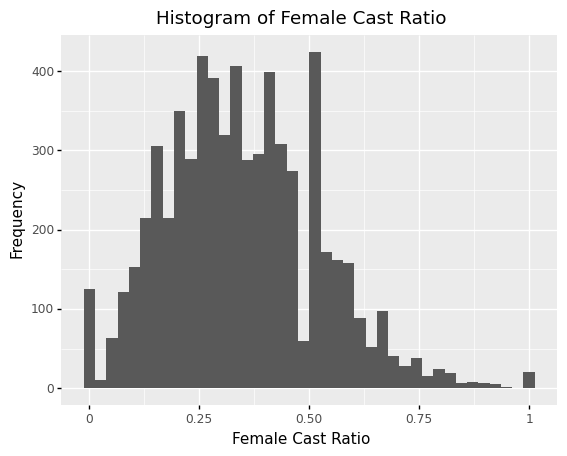

<ggplot: (-9223363248183863310)>

In [22]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x="cast_female_ratio")) + 
    geom_histogram() + 
    labs(
        title = 'Histogram of Female Cast Ratio',
        x = 'Female Cast Ratio',
        y = 'Frequency'
    )
)

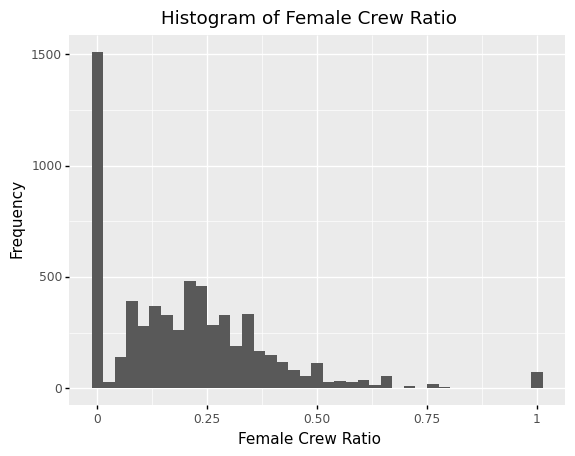

<ggplot: (8788682579590)>

In [23]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x="crew_female_ratio")) + 
    geom_histogram() + 
    labs(
        title = 'Histogram of Female Crew Ratio',
        x = 'Female Crew Ratio',
        y = 'Frequency'
    )
)

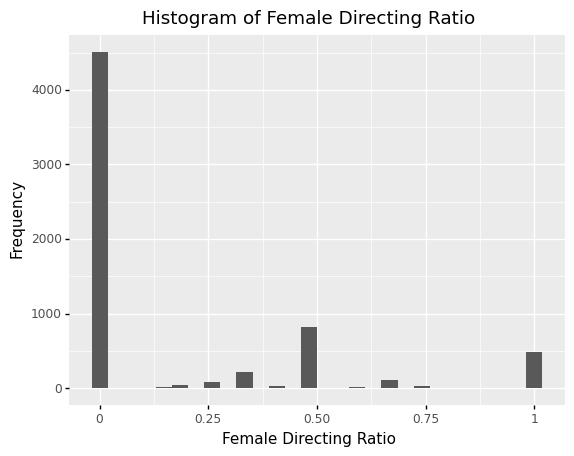

<ggplot: (8788683330196)>

In [24]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x="directing_female_ratio")) + 
    geom_histogram() + 
    labs(
        title = 'Histogram of Female Directing Ratio',
        x = 'Female Directing Ratio',
        y = 'Frequency'
    )
)

In [25]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x="directing_female_binary")) + 
#     geom_bar() + 
#     geom_text(
#         aes(label=after_stat('count')),
#         stat='count',
#         nudge_y=0.125,
#         va='bottom'
#     ) +
#     labs(
#         title = 'Histogram of Female Directing Binary',
#         x = 'Female Directing Binary',
#         y = 'Frequency'
#     )
# )

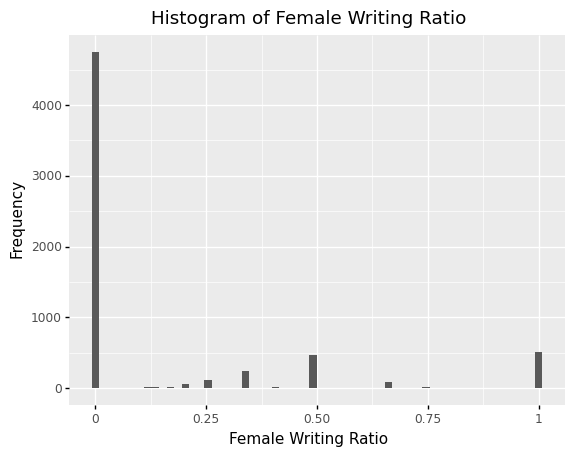

<ggplot: (8788682750356)>

In [26]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x="writing_female_ratio")) + 
    geom_histogram() + 
    labs(
        title = 'Histogram of Female Writing Ratio',
        x = 'Female Writing Ratio',
        y = 'Frequency'
    )
)

In [27]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x="writing_female_binary")) + 
#     geom_bar() + 
#     geom_text(
#         aes(label=after_stat('count')),
#         stat='count',
#         nudge_y=0.125,
#         va='bottom'
#     ) +
#     labs(
#         title = 'Histogram of Female Writing Binary',
#         x = 'Female Writing Binary',
#         y = 'Frequency'
#     )
# )

In [28]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x="production_female_ratio")) + 
#     geom_histogram() + 
#     labs(
#         title = 'Histogram of Female Production Ratio',
#         x = 'Female Production Ratio',
#         y = 'Frequency'
#     )
# )

In [29]:
bechdel_df_no_nan_no_dubious.groupby('bt_score').mean()

,year,dubious,cast_female_ratio,crew_female_ratio,directing_female_ratio,writing_female_ratio
bt_score,,,,,,
0.0,1985.351199,0.0,0.175370,0.130025,0.109409,0.059968
1.0,1994.583439,0.0,0.267505,0.160701,0.129250,0.061081
2.0,1989.766467,0.0,0.323381,0.164229,0.132578,0.078943
3.0,1997.059116,0.0,0.423693,0.242700,0.220220,0.230234


For all the ratios (binary values), we can see that the means seem quite different, and seem to have a positive correlation with the bt_score.

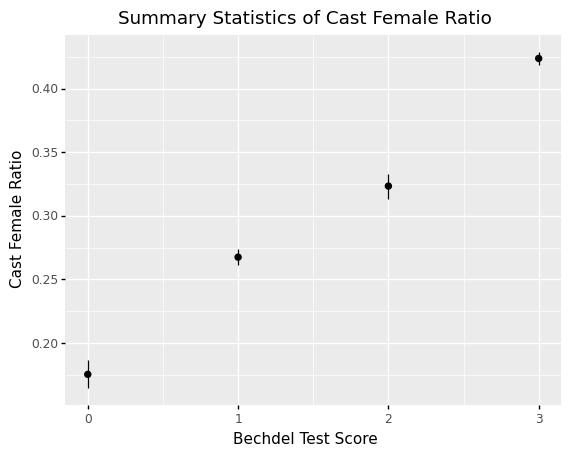

<ggplot: (8788682908971)>

In [30]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='cast_female_ratio')) + 
        stat_summary() + 
    labs(
        title = 'Summary Statistics of Cast Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Cast Female Ratio',
    ) 
    # + theme_matplotlib()
)

The dot represents the mean and the error bar represent mean standard error. 

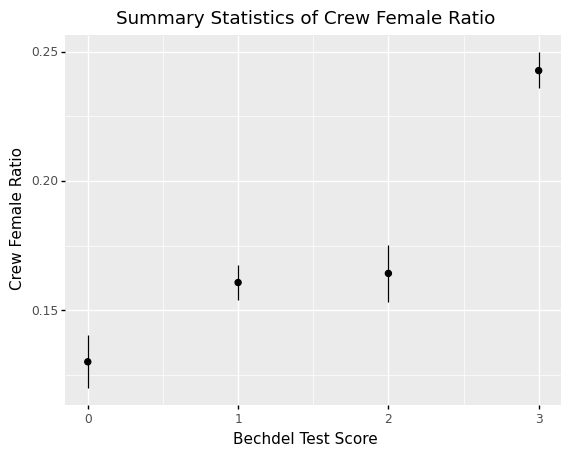

<ggplot: (-9223363248217379689)>

In [31]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='crew_female_ratio')) + 
        stat_summary() + 
    labs(
        title = 'Summary Statistics of Crew Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Crew Female Ratio',
    )
)

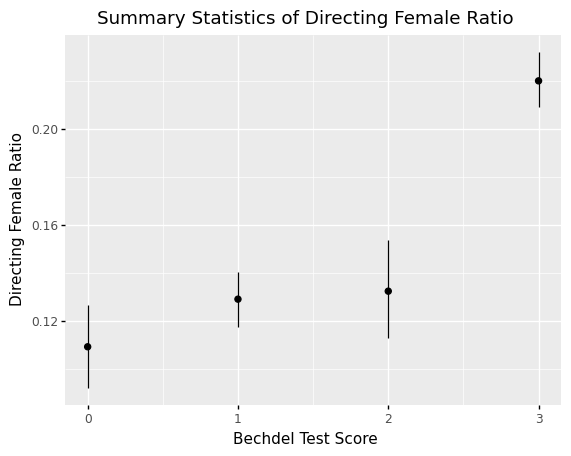

<ggplot: (8788683034944)>

In [32]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='directing_female_ratio')) + 
        stat_summary() + 
    labs(
        title = 'Summary Statistics of Directing Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Directing Female Ratio',
    )
)

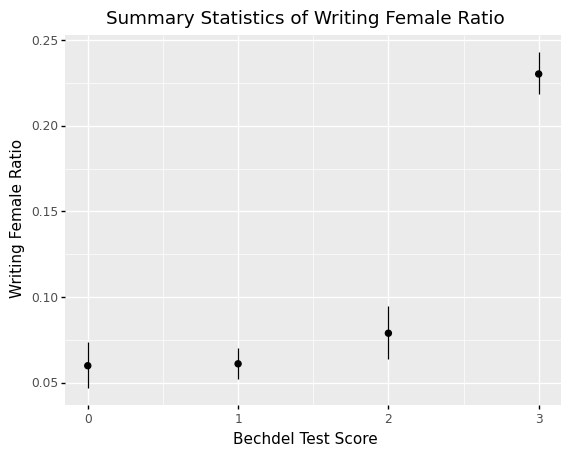

<ggplot: (8788682760028)>

In [33]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='writing_female_ratio')) + 
        stat_summary() + 
    labs(
        title = 'Summary Statistics of Writing Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Writing Female Ratio',
    )
)

# Legacy Code

Things I tried but did not use in the end. You do not need to keep running this part. 

### Boxplots

In [35]:
# convert bt_scores from float to string, so that they can be recognized as categorical
bechdel_df_no_nan_no_dubious['bt_score'] = bechdel_df_no_nan_no_dubious['bt_score'].astype(str)

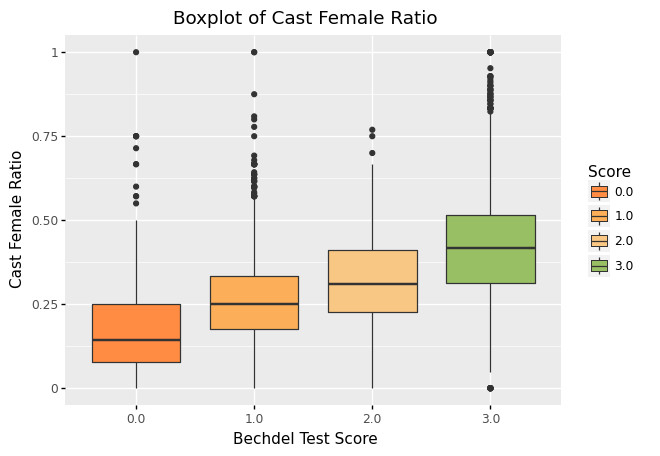

<ggplot: (-9223363248171980235)>

In [37]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='cast_female_ratio', fill='bt_score')) +
    geom_boxplot() + 
    labs(
        title = 'Boxplot of Cast Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Cast Female Ratio',
        fill = 'Score'
    ) + 
    scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
)

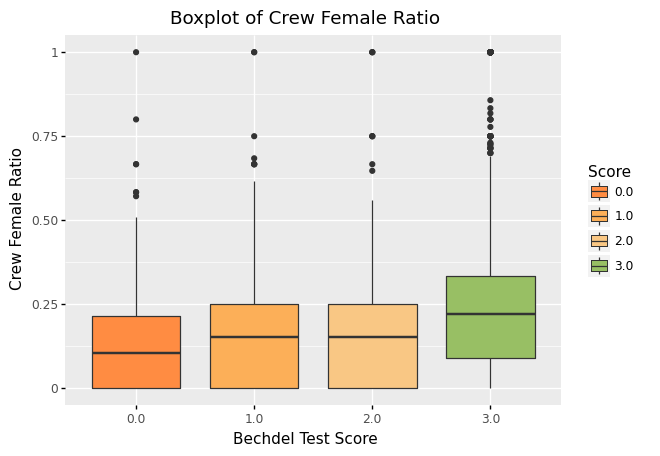

<ggplot: (8788637862902)>

In [38]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='crew_female_ratio', fill='bt_score')) +
    geom_boxplot() + 
    labs(
        title = 'Boxplot of Crew Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Crew Female Ratio',
        fill = 'Score'
    ) + 
    scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
)

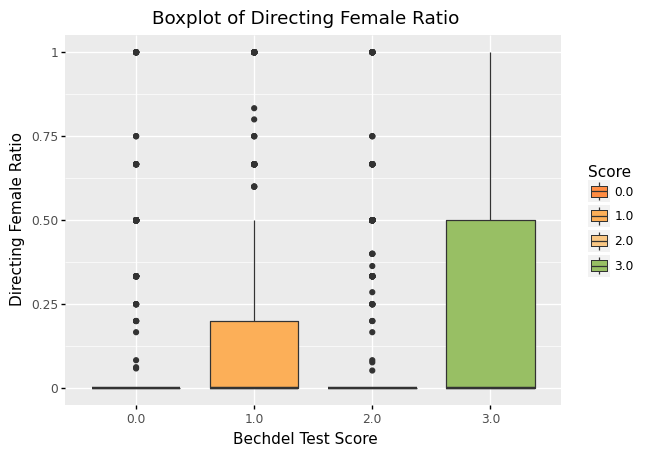

<ggplot: (-9223363248216751623)>

In [39]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='directing_female_ratio', fill='bt_score')) +
    geom_boxplot() + 
    labs(
        title = 'Boxplot of Directing Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Directing Female Ratio',
        fill = 'Score'
    ) + 
    scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
)

In [44]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x='bt_score', y='directing_female_binary')) +
#     geom_point() + 
#     labs(
#         title = 'Boxplot of Directing Female Binary',
#         x = 'Bechdel Test Score', 
#         y = 'Directing Female Binary',
#         fill = 'Score'
#     ) + 
#     scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
# )

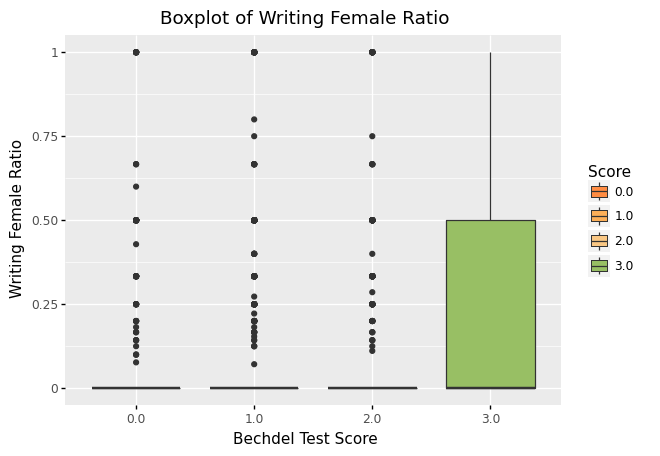

<ggplot: (-9223363248216156167)>

In [45]:
(ggplot(bechdel_df_no_nan_no_dubious,
        aes(x='bt_score', y='writing_female_ratio', fill='bt_score')) +
    geom_boxplot() + 
    labs(
        title = 'Boxplot of Writing Female Ratio',
        x = 'Bechdel Test Score', 
        y = 'Writing Female Ratio',
        fill = 'Score'
    ) + 
    scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
)

In [46]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x='bt_score', y='writing_female_binary', fill='bt_score')) +
#     geom_boxplot() + 
#     labs(
#         title = 'Boxplot of Writing Female Binary',
#         x = 'Bechdel Test Score', 
#         y = 'Writing Female Binary',
#         fill = 'Score'
#     ) + 
#     scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
# )

In [48]:
# (ggplot(bechdel_df_no_nan_no_dubious,
#         aes(x='bt_score', y='production_female_ratio', fill='bt_score')) +
#     geom_boxplot() + 
#     labs(
#         title = 'Boxplot of Production Female Ratio',
#         x = 'Bechdel Test Score', 
#         y = 'Production Female Ratio',
#         fill = 'Score'
#     ) + 
#     scale_fill_manual(values=['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
# )

If we look at the boxplots, we are no longer so sure if the distributions are really that different anymore. That is why we need ANOVA.

## One-way ANOVA

Although it might be tempting to draw conclusion from just the means, we need more sophisticated statistical methods to do infer conclusions about the population. 

https://towardsdatascience.com/introduction-to-one-way-anova-a-test-to-compare-the-means-between-more-than-two-groups-a656cb53b19c

https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/

In [ ]:
# uncomment and run the line below if you haven't installed this package
# %pip install statsmodels

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import levene
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot

### Cast Female Ratio

In [ ]:
# ANOVA
model_cast = ols("cast_female_ratio ~ C(bt_score)", bechdel_df_no_nan_no_dubious).fit()
res_cast = anova_lm(model_cast, typ=1)
res_cast

,df,sum_sq,mean_sq,F,PR(>F)
C(bt_score),3.0,51.353178,17.117726,780.171099,0.0
Residual,6372.0,139.807985,0.021941,NaN,NaN


There is a statistically significant difference between movies with different bechdel scores. But which groups are different? We need to compare pair-wise. 

In [ ]:
# Tukey's HSD test
comparison_cast = MultiComparison(bechdel_df_no_nan_no_dubious["cast_female_ratio"], bechdel_df_no_nan_no_dubious["bt_score"])
comparison_cast_results = comparison_cast.tukeyhsd()
comparison_cast_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,1.0,0.0921,0.001,0.0749,0.1093,True
0.0,2.0,0.148,0.001,0.1275,0.1685,True
0.0,3.0,0.2483,0.001,0.2326,0.264,True
1.0,2.0,0.0559,0.001,0.0383,0.0734,True
1.0,3.0,0.1562,0.001,0.1446,0.1678,True
2.0,3.0,0.1003,0.001,0.0842,0.1164,True


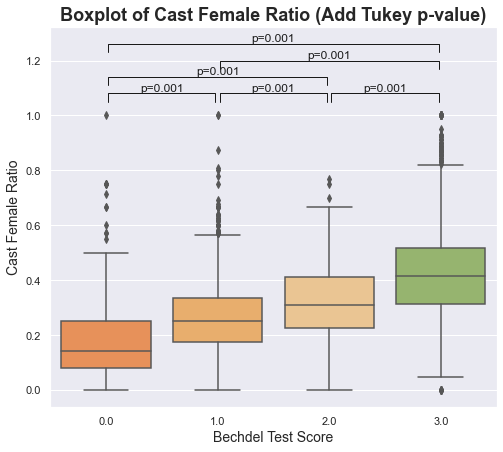

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,7)})
sns.set_palette(['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
sns.boxplot(x="bt_score", y="cast_female_ratio", data=bechdel_df_no_nan_no_dubious)

# statistical annotation
x0, x1, x2, x3 = 0, 1, 2, 3
gap = 0.02
y, h, col = bechdel_df_no_nan_no_dubious['cast_female_ratio'].max() + 0.05, 0.03, 'k'

plt.plot([x0+gap, x0+gap, x1-gap, x1-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x0+x1)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x1+gap, x1+gap, x2-gap, x2-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x2+gap, x2+gap, x3-gap, x3-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x2+x3)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x2-gap, x2-gap], [y+2*h, y+3*h, y+3*h, y+2*h], lw=1, c=col)
plt.text((x0+x2)*.5, y+3*h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x1+gap, x1+gap, x3-gap, x3-gap], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1, c=col)
plt.text((x1+x3)*.5, y+5*h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x3-gap, x3-gap], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1, c=col)
plt.text((x0+x3)*.5, y+7*h, "p=0.001", ha='center', va='bottom', color=col)

plt.title("Boxplot of Cast Female Ratio (Add Tukey p-value)", weight='bold').set_fontsize('18')
# sns.plt.title('I AM A TITLE', weight='bold').set_fontsize('18')
plt.xlabel('Bechdel Test Score').set_fontsize('14')
plt.ylabel('Cast Female Ratio').set_fontsize('14')

plt.show()

It seems like every pair is different. 

Now let's check the assumptions of ANOVA:

- Normal Distribution
- homoscedasticity

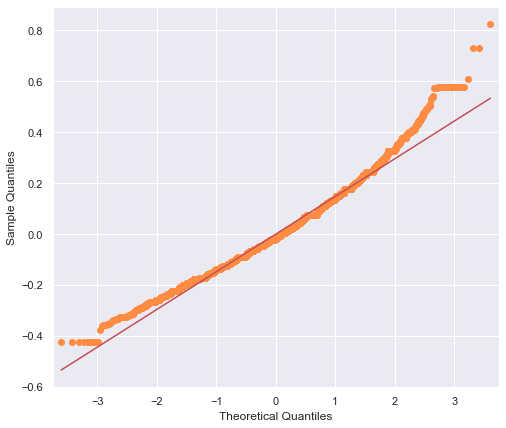

In [ ]:
# Normality Test
residuals_cast = model_cast.resid
plot_cast = qqplot(residuals_cast, line="s")

Overall, normality seems to hold. 

In [ ]:
group3_cast = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '3.0']['cast_female_ratio'])
group2_cast = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '2.0']['cast_female_ratio'])
group1_cast = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '1.0']['cast_female_ratio'])
group0_cast = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '0.0']['cast_female_ratio'])
stat_cast, p_cast = levene(group3_cast, group2_cast, group1_cast, group0_cast)
p_cast

2.96215635837524e-23

Great! There doesn't seem to be a heteroscedasticity problem. 

### Crew Female Ratio

                 df      sum_sq   mean_sq           F        PR(>F)
C(bt_score)     3.0   12.983480  4.327827  136.296743  1.375532e-85
Residual     6372.0  202.329944  0.031753         NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0307  0.001    0.01 0.0514   True
   0.0    2.0   0.0342 0.0021  0.0095 0.0589   True
   0.0    3.0   0.1127  0.001  0.0938 0.1316   True
   1.0    2.0   0.0035    0.9 -0.0176 0.0247  False
   1.0    3.0    0.082  0.001  0.0681 0.0959   True
   2.0    3.0   0.0785  0.001  0.0591 0.0978   True
---------------------------------------------------


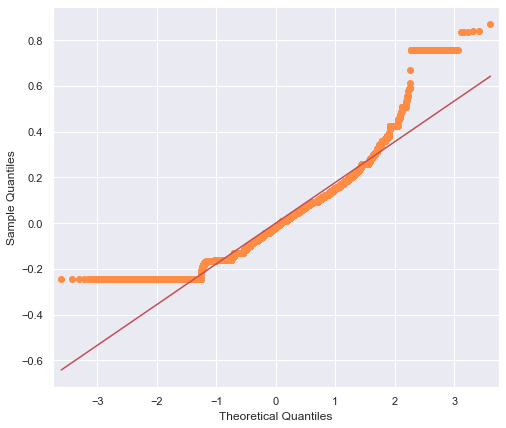

In [ ]:
# ANOVA
model_crew = ols("crew_female_ratio ~ C(bt_score)", bechdel_df_no_nan_no_dubious).fit()
res_crew = anova_lm(model_crew, typ=1)
print(res_crew)
# Tukey's HSD test
comparison_crew = MultiComparison(bechdel_df_no_nan_no_dubious["crew_female_ratio"], bechdel_df_no_nan_no_dubious["bt_score"])
comparison_crew_results = comparison_crew.tukeyhsd()
print(comparison_crew_results.summary())
# Normality Test
residuals_crew = model_crew.resid
plot_crew = qqplot(residuals_crew, line="s")
plot_crew.show()

This seems to be a pretty big violation. Let's compare medium instead. 

https://www.researchgate.net/post/I_am_planing_to_do_ANOVA_test_on_my_data_but_the_data_are_not_normally_distributed_even_after_transformation_eg_log_Box-Cox_What_should_I_do

In [ ]:
group3_crew = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '3.0']['crew_female_ratio'])
group2_crew = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '2.0']['crew_female_ratio'])
group1_crew = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '1.0']['crew_female_ratio'])
group0_crew = list(bechdel_df_no_nan_no_dubious[bechdel_df_no_nan_no_dubious['bt_score'] == '0.0']['crew_female_ratio'])
stats.kruskal(group3_crew, group2_crew, group1_crew, group0_crew)

KruskalResult(statistic=344.0362858325463, pvalue=2.9172175894063935e-74)

This is supporting ANOVA's conclusion. Nice. 

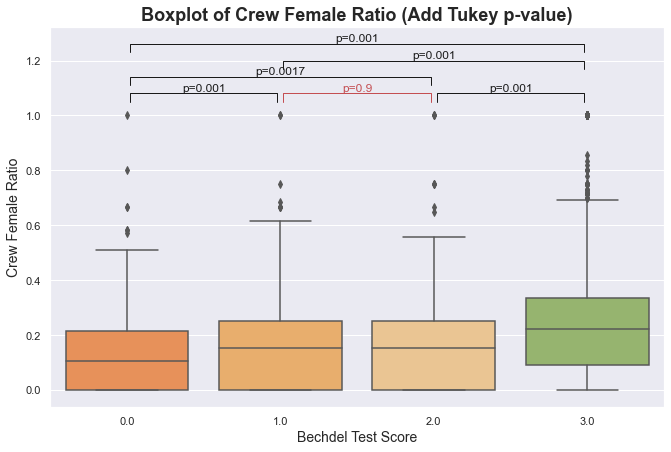

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,7)})
sns.set_palette(['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
sns.boxplot(x="bt_score", y="crew_female_ratio", data=bechdel_df_no_nan_no_dubious)

# statistical annotation
x0, x1, x2, x3 = 0, 1, 2, 3
gap = 0.02
y, h, col = bechdel_df_no_nan_no_dubious['cast_female_ratio'].max() + 0.05, 0.03, 'k'

plt.plot([x0+gap, x0+gap, x1-gap, x1-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x0+x1)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x1+gap, x1+gap, x2-gap, x2-gap], [y, y+h, y+h, y], lw=1, c='r')
plt.text((x1+x2)*.5, y+h, "p=0.9", ha='center', va='bottom', color='r')

plt.plot([x2+gap, x2+gap, x3-gap, x3-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x2+x3)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x2-gap, x2-gap], [y+2*h, y+3*h, y+3*h, y+2*h], lw=1, c=col)
plt.text((x0+x2)*.5, y+3*h, "p=0.0017", ha='center', va='bottom', color=col)

plt.plot([x1+gap, x1+gap, x3-gap, x3-gap], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1, c=col)
plt.text((x1+x3)*.5, y+5*h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x3-gap, x3-gap], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1, c=col)
plt.text((x0+x3)*.5, y+7*h, "p=0.001", ha='center', va='bottom', color=col)

plt.title("Boxplot of Crew Female Ratio (Add Tukey p-value)", weight='bold').set_fontsize('18')
plt.xlabel('Bechdel Test Score').set_fontsize('14')
plt.ylabel('Crew Female Ratio').set_fontsize('14')

plt.show()

### Directing Female Ratio

                 df      sum_sq   mean_sq          F        PR(>F)
C(bt_score)     3.0   14.542526  4.847509  52.418308  1.840001e-33
Residual     6372.0  589.265978  0.092477        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0198 0.4731 -0.0155 0.0552  False
   0.0    2.0   0.0232 0.4915  -0.019 0.0653  False
   0.0    3.0   0.1108  0.001  0.0786 0.1431   True
   1.0    2.0   0.0033    0.9 -0.0327 0.0394  False
   1.0    3.0    0.091  0.001  0.0672 0.1147   True
   2.0    3.0   0.0876  0.001  0.0546 0.1207   True
---------------------------------------------------


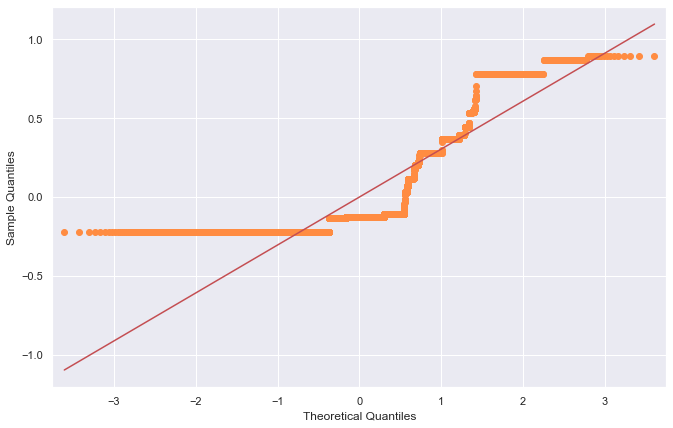

In [ ]:
# ANOVA
model_directing = ols("directing_female_ratio ~ C(bt_score)", bechdel_df_no_nan_no_dubious).fit()
res_directing = anova_lm(model_directing, typ=1)
print(res_directing)
# Tukey's HSD test
comparison_directing = MultiComparison(bechdel_df_no_nan_no_dubious["directing_female_ratio"], bechdel_df_no_nan_no_dubious["bt_score"])
comparison_directing_results = comparison_directing.tukeyhsd()
print(comparison_directing_results.summary())
# Normality Test
residuals_directing = model_directing.resid
plot_directing = qqplot(residuals_directing, line="s")
plot_directing.show()

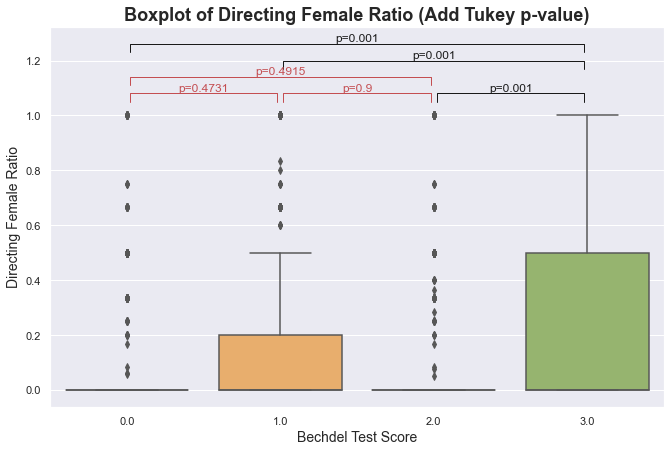

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,7)})
sns.set_palette(['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
sns.boxplot(x="bt_score", y="directing_female_ratio", data=bechdel_df_no_nan_no_dubious)

# statistical annotation
x0, x1, x2, x3 = 0, 1, 2, 3
gap = 0.02
y, h, col = bechdel_df_no_nan_no_dubious['cast_female_ratio'].max() + 0.05, 0.03, 'k'

plt.plot([x0+gap, x0+gap, x1-gap, x1-gap], [y, y+h, y+h, y], lw=1, c='r')
plt.text((x0+x1)*.5, y+h, "p=0.4731", ha='center', va='bottom', color='r')

plt.plot([x1+gap, x1+gap, x2-gap, x2-gap], [y, y+h, y+h, y], lw=1, c='r')
plt.text((x1+x2)*.5, y+h, "p=0.9", ha='center', va='bottom', color='r')

plt.plot([x2+gap, x2+gap, x3-gap, x3-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x2+x3)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x2-gap, x2-gap], [y+2*h, y+3*h, y+3*h, y+2*h], lw=1, c='r')
plt.text((x0+x2)*.5, y+3*h, "p=0.4915", ha='center', va='bottom', color='r')

plt.plot([x1+gap, x1+gap, x3-gap, x3-gap], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1, c=col)
plt.text((x1+x3)*.5, y+5*h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x3-gap, x3-gap], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1, c=col)
plt.text((x0+x3)*.5, y+7*h, "p=0.001", ha='center', va='bottom', color=col)

plt.title("Boxplot of Directing Female Ratio (Add Tukey p-value)", weight='bold').set_fontsize('18')
plt.xlabel('Bechdel Test Score').set_fontsize('14')
plt.ylabel('Directing Female Ratio').set_fontsize('14')

plt.show()

### Writing Female Ratio

                 df      sum_sq    mean_sq           F         PR(>F)
C(bt_score)     3.0   43.547700  14.515900  171.630564  5.276256e-107
Residual     6372.0  538.920998   0.084576         NaN            NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    1.0   0.0011   0.9 -0.0327 0.0349  False
   0.0    2.0    0.019 0.606 -0.0213 0.0593  False
   0.0    3.0   0.1703 0.001  0.1394 0.2011   True
   1.0    2.0   0.0179 0.538 -0.0166 0.0523  False
   1.0    3.0   0.1692 0.001  0.1464 0.1919   True
   2.0    3.0   0.1513 0.001  0.1197 0.1829   True
--------------------------------------------------


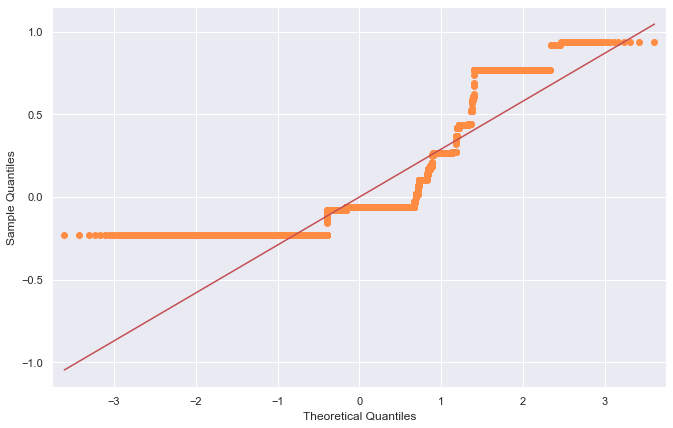

In [ ]:
# ANOVA
model_writing = ols("writing_female_ratio ~ C(bt_score)", bechdel_df_no_nan_no_dubious).fit()
res_writing = anova_lm(model_writing, typ=1)
print(res_writing)
# Tukey's HSD test
comparison_writing = MultiComparison(bechdel_df_no_nan_no_dubious["writing_female_ratio"], bechdel_df_no_nan_no_dubious["bt_score"])
comparison_writing_results = comparison_writing.tukeyhsd()
print(comparison_writing_results.summary())
# Normality Test
residuals_writing = model_writing.resid
plot_writing = qqplot(residuals_writing, line="s")
plot_writing.show()

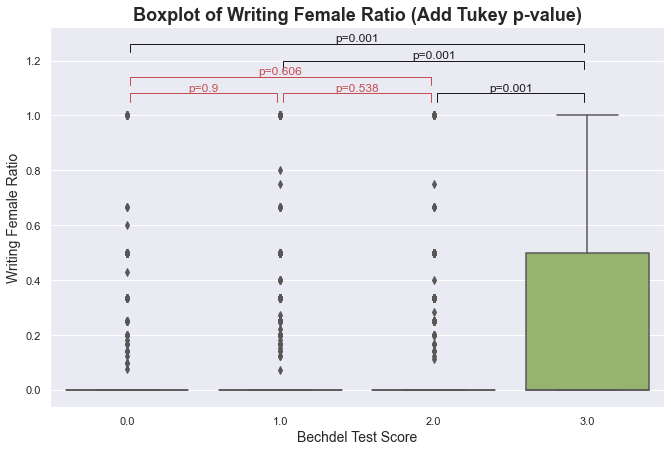

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11,7)})
sns.set_palette(['#FF8C42', '#FCAF58', '#F9C784', '#98BF64'])
sns.boxplot(x="bt_score", y="writing_female_ratio", data=bechdel_df_no_nan_no_dubious)

# statistical annotation
x0, x1, x2, x3 = 0, 1, 2, 3
gap = 0.02
y, h, col = bechdel_df_no_nan_no_dubious['cast_female_ratio'].max() + 0.05, 0.03, 'k'

plt.plot([x0+gap, x0+gap, x1-gap, x1-gap], [y, y+h, y+h, y], lw=1, c='r')
plt.text((x0+x1)*.5, y+h, "p=0.9", ha='center', va='bottom', color='r')

plt.plot([x1+gap, x1+gap, x2-gap, x2-gap], [y, y+h, y+h, y], lw=1, c='r')
plt.text((x1+x2)*.5, y+h, "p=0.538", ha='center', va='bottom', color='r')

plt.plot([x2+gap, x2+gap, x3-gap, x3-gap], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x2+x3)*.5, y+h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x2-gap, x2-gap], [y+2*h, y+3*h, y+3*h, y+2*h], lw=1, c='r')
plt.text((x0+x2)*.5, y+3*h, "p=0.606", ha='center', va='bottom', color='r')

plt.plot([x1+gap, x1+gap, x3-gap, x3-gap], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1, c=col)
plt.text((x1+x3)*.5, y+5*h, "p=0.001", ha='center', va='bottom', color=col)

plt.plot([x0+gap, x0+gap, x3-gap, x3-gap], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1, c=col)
plt.text((x0+x3)*.5, y+7*h, "p=0.001", ha='center', va='bottom', color=col)

plt.title("Boxplot of Writing Female Ratio (Add Tukey p-value)", weight='bold').set_fontsize('18')
plt.xlabel('Bechdel Test Score').set_fontsize('14')
plt.ylabel('Writing Female Ratio').set_fontsize('14')

plt.show()

## Regression

I personally don't see the point of building a regression model, because I don't see why it would be important or interesting to predict eg: cast female ratio, bt score. 

And this will honestly be a very complicated regression model. We have 1 categorial variable and 5 continuous variable. The one categorical variable has 4 categories. Normally, after dummy coding or one-hot coding, we will be looking at 8-9 features, not to mention the interaction effect. In our case, the categorical variable can actually be treated as a continuous variable, because we can treat it (ordinal) as an interval or even ratio measurement. 

But does it really matter? Does a regression really tell us anything? There would be too many interactions going on (even for those that doesn't concern the bechdel test) that we cannot really tell what is acutally helping. I think it is a better idea to stick to ANOVA and compare bechdel to the others. Our focus is the bechdel test. 

But anyways, here we try this:

### Data Preperation

In [53]:
bechdel_df_no_nan_no_dubious.head()

,index,title,year,bt_score,dubious,cast,crew,cast_female_ratio,crew_female_ratio,directing_female_ratio,directing_female_binary,writing_female_ratio,writing_female_binary
0,31,"House of the Devil, The",1896.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Mephistopheles',...","[{'credit_id': '52fe4ba5c3a368484e192f61', 'de...",0.500000,0.000000,0.0,0,0.0,0
1,32,Une nuit terrible,1896.0,0.0,0.0,"[{'cast_id': 2, 'character': ""L'homme qui essa...","[{'credit_id': '52fe4a35c3a36847f81c0f2b', 'de...",0.000000,0.000000,0.0,0,0.0,0
2,39,Cinderella,1899.0,3.0,0.0,"[{'cast_id': 3, 'character': ""Le gnome de la p...","[{'credit_id': '52fe4b45c3a36847f81fb5cb', 'de...",0.333333,0.000000,0.0,0,0.0,0
3,44,Bluebeard,1901.0,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '52fe478dc3a36847f813bd37', 'de...",0.666667,0.000000,0.0,0,0.0,0
4,45,Le voyage dans la lune,1902.0,0.0,0.0,"[{'cast_id': 11, 'character': 'Professeur Barb...","[{'credit_id': '52fe4275c3a36847f8020161', 'de...",0.181818,0.083333,0.0,0,0.0,0


<AxesSubplot:>

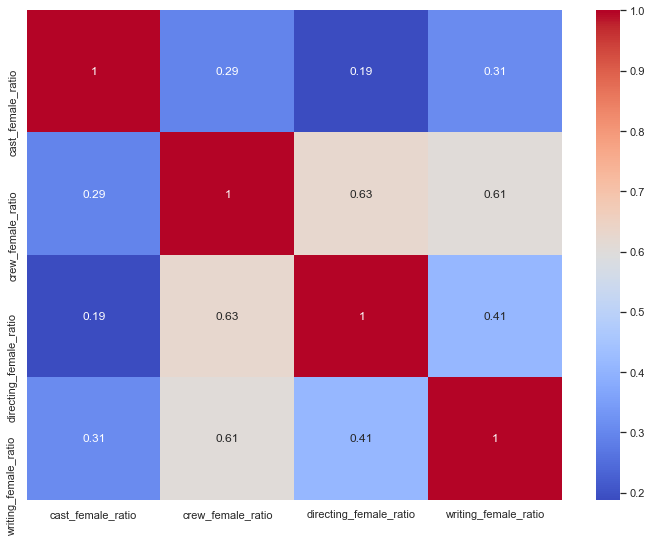

In [55]:
correlation = bechdel_df_no_nan_no_dubious[['bt_score', 'cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

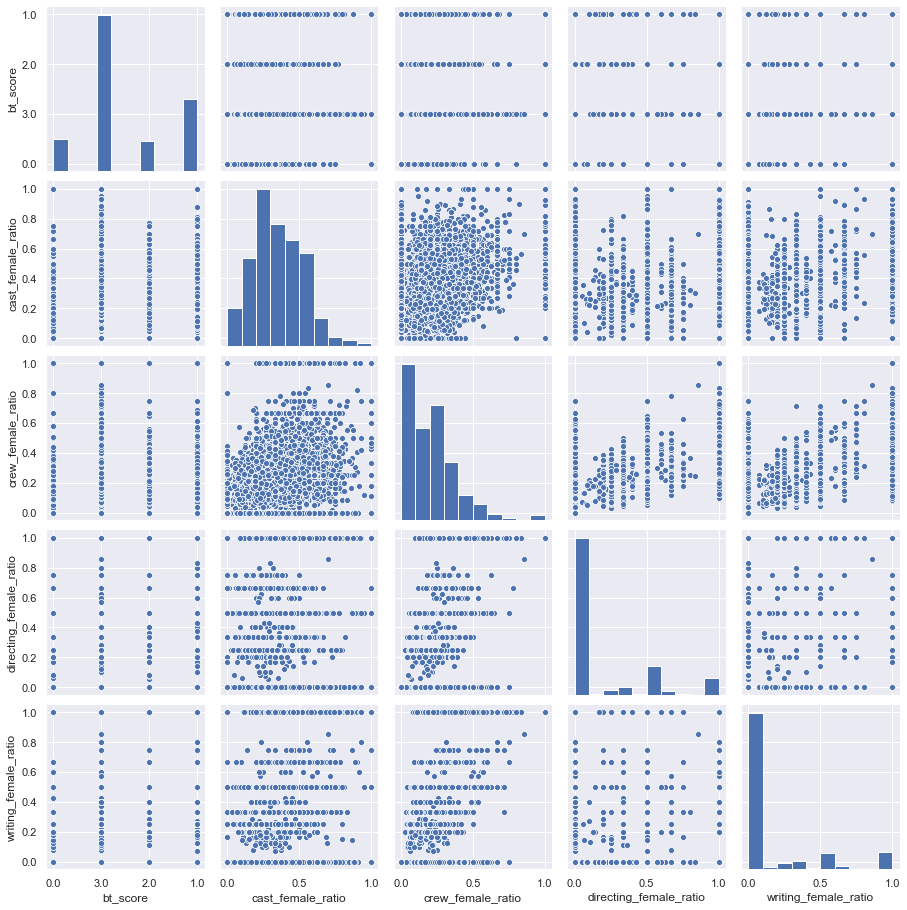

In [57]:
#scatterplot
sns.set()
cols = ['bt_score', 'cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']
sns.pairplot(bechdel_df_no_nan_no_dubious[cols], size = 2.5)
plt.show()

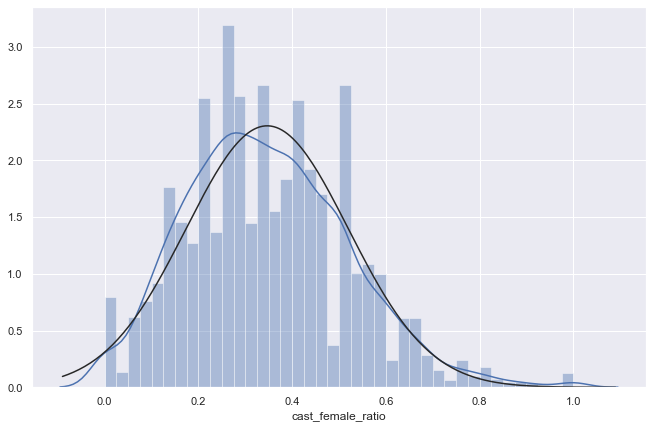

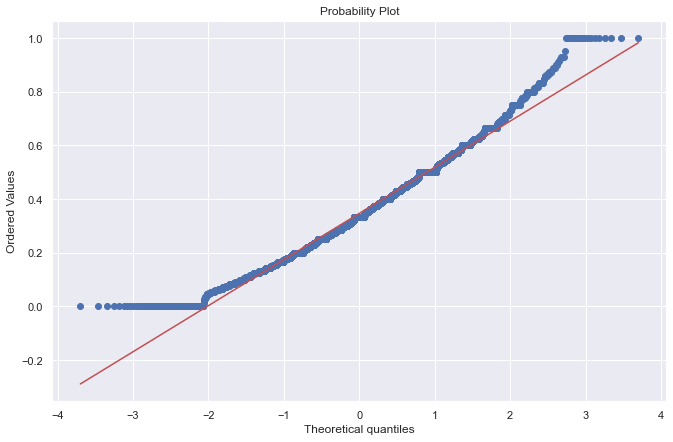

In [58]:
sns.distplot(bechdel_df_no_nan_no_dubious['cast_female_ratio'], fit=norm)
fig = plt.figure()
res = stats.probplot(bechdel_df_no_nan_no_dubious['cast_female_ratio'], plot=plt)

This is a little bit negatively skewed. Let's try to fix it. 

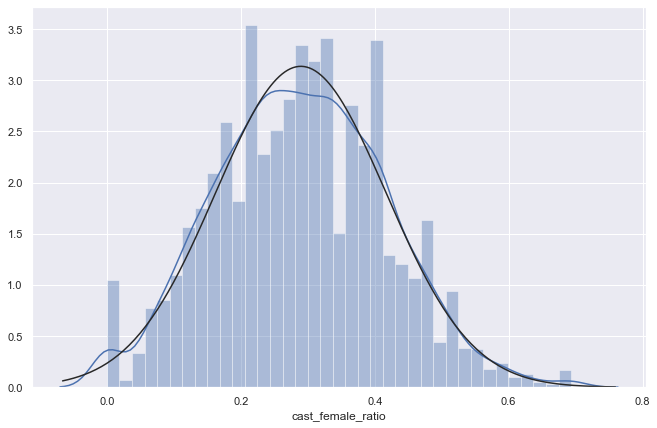

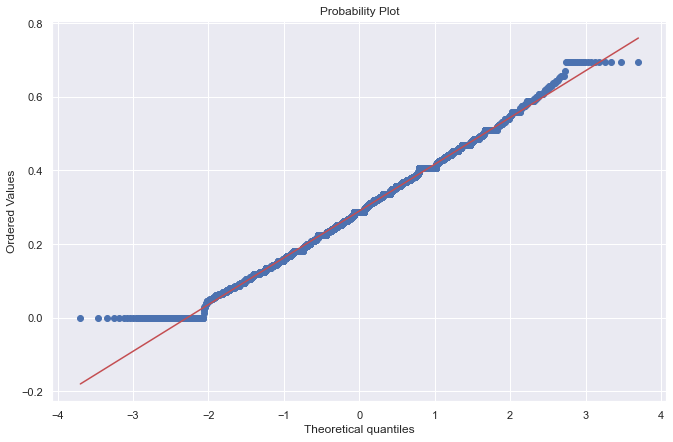

In [59]:
log_cast_female_ratio = np.log(bechdel_df_no_nan_no_dubious['cast_female_ratio']+1)
sns.distplot(log_cast_female_ratio, fit=norm)
fig = plt.figure()
res = stats.probplot(log_cast_female_ratio, plot=plt)

I don't really see a significant improvement. Let's keep the original one. 

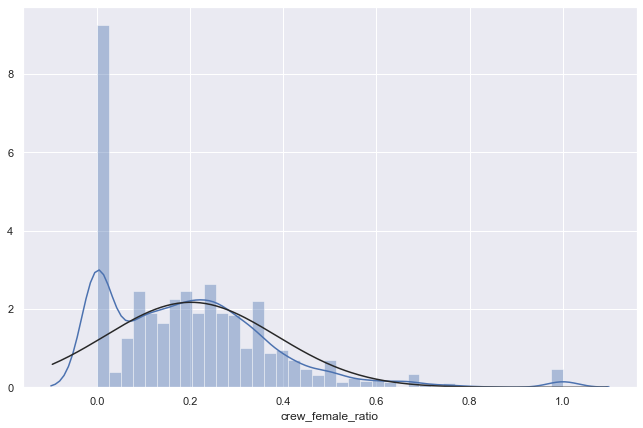

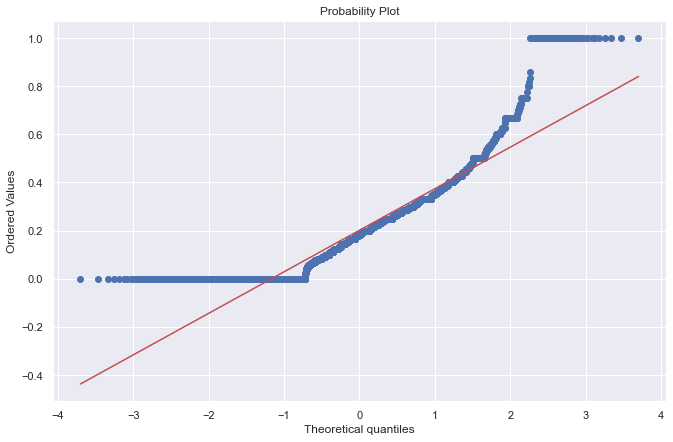

In [60]:
sns.distplot(bechdel_df_no_nan_no_dubious['crew_female_ratio'], fit=norm)
fig = plt.figure()
res = stats.probplot(bechdel_df_no_nan_no_dubious['crew_female_ratio'], plot=plt)

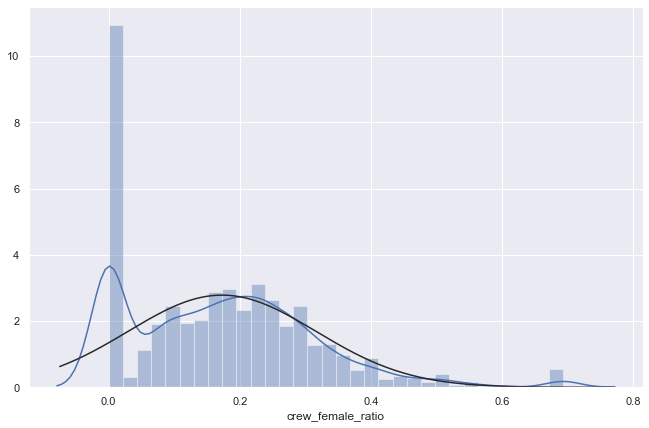

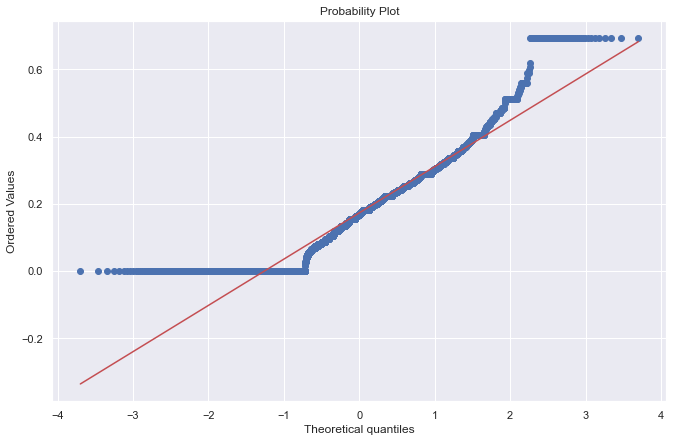

In [61]:
log_crew_female_ratio = np.log(bechdel_df_no_nan_no_dubious['crew_female_ratio'] + 1)
sns.distplot(log_crew_female_ratio, fit=norm)
fig = plt.figure()
res = stats.probplot(log_crew_female_ratio, plot=plt)

Again, not much improvement. Let's keep the original one. 

### Fit Model

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [63]:
# prep data
X = bechdel_df_no_nan_no_dubious[['bt_score', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']] #, 'production_female_ratio']]
y = bechdel_df_no_nan_no_dubious['cast_female_ratio']

In [64]:
model = LinearRegression(normalize=True)
model.fit(X,y)

LinearRegression(normalize=True)

In [65]:
# print the coefficients and intercept
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)
print('Intercept                  ', model.intercept_)

                        Coefficient
bt_score                   0.071736
crew_female_ratio          0.103307
directing_female_ratio    -0.000480
writing_female_ratio       0.073280
Intercept                   0.16666338949318343


In [66]:
# prep data
X = bechdel_df_no_nan_no_dubious[['cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']] #, 'production_female_ratio']]
y = bechdel_df_no_nan_no_dubious['bt_score']
model = LinearRegression(normalize=True)
model.fit(X,y)
# print the coefficients and intercept
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)
print('Intercept                  ', model.intercept_)

                        Coefficient
cast_female_ratio          3.059378
crew_female_ratio          0.330415
directing_female_ratio    -0.030117
writing_female_ratio       0.276121
Intercept                   0.9006684100049296


## Classifier

Output: Bechdel Test Score
Input: ratios

- logistic regression

- random forest

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [93]:
X = bechdel_df_no_nan_no_dubious[['cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']]
y = bechdel_df_no_nan_no_dubious['bt_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

## Multi Logistic Regression

<!-- https://www.youtube.com/watch?v=m9ChJ4TWVXY&ab_channel=EvidenceN -->

In [95]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.5979623824451411
              precision    recall  f1-score   support

         0.0       0.57      0.29      0.38       146
         1.0       0.46      0.41      0.43       317
         2.0       0.00      0.00      0.00       146
         3.0       0.64      0.89      0.74       667

    accuracy                           0.60      1276
   macro avg       0.42      0.40      0.39      1276
weighted avg       0.52      0.60      0.54      1276



## Random Forest

<!-- https://www.datacamp.com/community/tutorials/random-forests-classifier-python -->

In [96]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.549373040752351
              precision    recall  f1-score   support

         0.0       0.47      0.34      0.40       146
         1.0       0.40      0.35      0.37       317
         2.0       0.18      0.08      0.11       146
         3.0       0.64      0.79      0.71       667

    accuracy                           0.55      1276
   macro avg       0.42      0.39      0.40      1276
weighted avg       0.51      0.55      0.52      1276



No handles with labels found to put in legend.


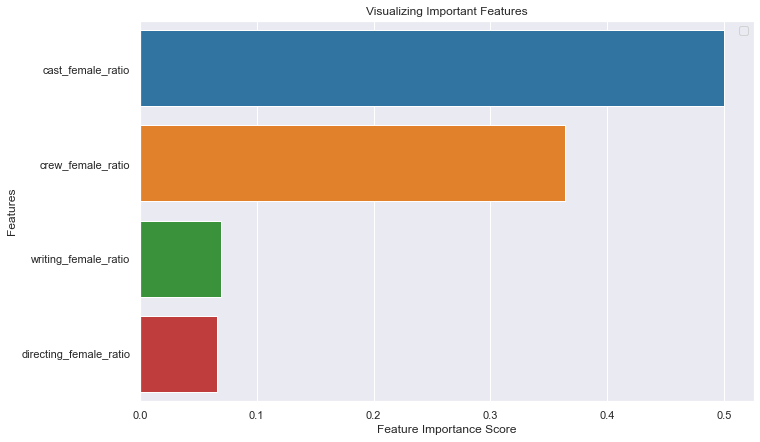

In [92]:
# feature importance
feature_imp = pd.Series(rf.feature_importances_, index=['cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio']).sort_values(ascending=False)

# Creating a bar plot
sns.set_palette("tab10")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Hierarchical Linear Regression

<!-- https://www.youtube.com/watch?v=9uo-Ug47jys&ab_channel=LordPusheen -->

Doing this by hand in Python is too much trouble, so I am going to output the data and do everything in SPSS (I am learning SPSS this semester!)

In [79]:
bechdel_df_no_nan_no_dubious[['cast_female_ratio', 'crew_female_ratio', 'directing_female_ratio', 'writing_female_ratio', 'bt_score']].to_csv('./SPSS/spss.csv')

I am not exactly sure what I am doing, but it seems that this confirms feature importance. 

![output](./SPSS/output.png 'output')

In [39]:
bechdel_df_no_nan_no_dubious.head()

,title,year,bt_score,dubious,cast,crew,cast_female_ratio,crew_female_ratio,directing_female_ratio,writing_female_ratio
0,"House of the Devil, The",1896.0,0.0,0.0,"[{'cast_id': 5, 'character': 'Mephistopheles',...","[{'credit_id': '52fe4ba5c3a368484e192f61', 'de...",0.500000,0.000000,0.0,0.0
1,Une nuit terrible,1896.0,0.0,0.0,"[{'cast_id': 2, 'character': ""L'homme qui essa...","[{'credit_id': '52fe4a35c3a36847f81c0f2b', 'de...",0.000000,0.000000,0.0,0.0
2,Cinderella,1899.0,3.0,0.0,"[{'cast_id': 3, 'character': ""Le gnome de la p...","[{'credit_id': '52fe4b45c3a36847f81fb5cb', 'de...",0.333333,0.000000,0.0,0.0
3,Bluebeard,1901.0,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '52fe478dc3a36847f813bd37', 'de...",0.666667,0.000000,0.0,0.0
4,Le voyage dans la lune,1902.0,0.0,0.0,"[{'cast_id': 11, 'character': 'Professeur Barb...","[{'credit_id': '52fe4275c3a36847f8020161', 'de...",0.181818,0.083333,0.0,0.0
